In [1]:
import os, sys
sys.path.append('..')
sys.path.insert(0,'../submodule/m-phate')
sys.path.insert(0,'../submodule/OASIS')

In [2]:
import numpy as np
import pandas as pd
from random import shuffle
import scipy
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from importlib import import_module
import math, random, pickle
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
from sys import path

from joblib import Parallel, delayed

import matlab.engine
import engine

from pyexperimentparser.dataset.dataset import  Dataset
from pyexperimentparser.experiment.experiment import  Experiment
from pyexperimentparser.trial.trial import Trial
from pyexperimentparser.trial.bda import BDA
from pyexperimentparser.trial.tpa import TPA
from pyexperimentparser.utils import preprocess
from pyexperimentparser.utils import utils

from importlib import import_module

from absl import app
from absl import logging
from absl import flags

In [3]:
import m_phate
#import OASIS
import numpy as np
import scprep
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans

In [4]:
def parse(config):
  pars = config['parameters']
  return pars

In [5]:
with open('../config.json', 'r') as json_file:
    config = json.load(json_file)

pars = parse(config)
trial_ind_show = 0
data_dir = pars['data_dir']
# special trial (repetition) to show (Change it if you need)
rois_per_trial_num = pars['rois_per_trial_num']
# frame rate ratio between Two Photon imaging and Behavior
frame_rate_ratio      = pars['frame_rate_ratio']
# Common names to be converted to Ids
event_name_list      = pars['event_name_list']

procs = pars['processors']
verbosity = pars['verbosity']

ds = Dataset(verbosity, procs, '')

In [6]:
dates_to_process = pars['dates_to_process'] # e.g. 8_13_17, 8_6_17, 8_7_17 are "expert" days
cell_type = pars['cell_type']  # soma

In [7]:
dates_to_process

['8_6_17', '8_7_17']

In [8]:
## if importing .mat, need to start a virtual matlab instance
#import engine
#engine.init()

In [9]:
#ds.mat_to_pkl(data_dir, pars)

In [10]:
ds.load_from_pkl(data_dir, pars)

loading dataset from pickle with 40 threads, 11 verbosity


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.


AttributeError: Can't get attribute 'Bda' on <module 'pyexperimentparser.trial.bda' from '../pyexperimentparser/trial/bda.py'>

In [11]:
len(ds.experiment_list)

2

In [12]:
for i, exp in enumerate(tqdm(ds.experiment_list)):
    #idx = [int(t.tpa_fname.split('_')[-5]) for t in exp.trial_list]
    idx = [tr.idx for tr in ds.experiment_list[0].trial_list]
    #print([t.bda_fname for t in exp.trial_list])
    #print(idx)
    #print([t.tpa_fname.split('_')[-5] for t in exp.trial_list])
    ds.experiment_list[i].trial_list = [x for _,x in sorted(zip(idx,exp.trial_list))]

In [13]:
#[tr.idx for tr in ds.experiment_list[0].trial_list]

In [14]:
Data_x = []
Data_y = []
trials_label_per_day_list = []
trials_per_day_list = []
for exp in tqdm(ds.experiment_list):
    event_name_per_trial = []
    data_per_trial = []
    success_per_trial = []
    for trial in exp.trial_list: 
        if len(trial.bda_list) < 1 or len(trial.tpa_list) < 1:
            continue
        # extract ROI df/F data
        rois_per_trial_num   = len(trial.tpa_list)
        dffData = trial.tpa_list[0].procROI
        framNum = dffData.shape[0]
        dffDataArray = np.tile(dffData, (rois_per_trial_num,1))
        roiNames = []

        for m in range(rois_per_trial_num):
            dffDataArray[m,:] = trial.tpa_list[m].procROI
            roiNames.append(trial.tpa_list[m].Name)

        # extract Event Time data
        eventsPerTrialNum   = len(trial.bda_list)
        timeData         = trial.bda_list[0].TimeInd
        eventDataArray   = np.zeros((framNum,eventsPerTrialNum))
        eventNames       = []

        for m in range(eventsPerTrialNum):
            timeInd     = np.array(trial.bda_list[m].tInd).flatten()
            timeInd     = np.round(timeInd/frame_rate_ratio) # transfers to time of the two photon

            timeInd     = np.concatenate(([1],[np.min(np.concatenate((timeInd, [framNum])))]))
            timeInd = np.sort(timeInd)
            eventDataArray[int(timeInd[0]):int(timeInd[1]),m] = 1
            eventNames.append((trial.bda_list[m].Name, trial.bda_list[m].SeqNum))
        event_name_per_trial.append(eventNames)
            
        if len(eventNames) > 1:
            Data_x.append(dffDataArray.T)
            data_per_trial.append(dffDataArray.T)
            if eventNames[1][0] == 'success':
                success_per_trial.append(1)
            else:
                success_per_trial.append(0)
    trials_label_per_day_list.append(event_name_per_trial)
    trials_per_day_list.append(data_per_trial)
    Data_y.append(success_per_trial)
#Data_x_subset = []
#Data_y_subset = []
#for i, x in enumerate(Data_x):
#    if x.shape[-1] == 379 and x.shape[0] == 360: # sanity check
#        Data_x_subwset.append(x)
#        Data_y_subset.append(Data_y[i])

In [15]:
len(trials_label_per_day_list[0])

70

In [21]:
activitypertrial = [[[activity[0].split(':')[0] for activity in trial] for trial in day] for day in trials_label_per_day_list]

In [17]:
activity2idx = list(set([s for d in activitypertrial for t in d for s in t]))

In [18]:
activitypertrial = [[activity2idx.index(x) for x in d] for day in activitypertrial for d in day ]

In [22]:
num_grabs_per_day = [[trial.count('Grab') for trial in d]for d in activitypertrial]

In [155]:
num_grabs_per_day

[[2,
  0,
  2,
  7,
  6,
  2,
  2,
  3,
  2,
  5,
  3,
  3,
  1,
  7,
  5,
  2,
  5,
  8,
  1,
  2,
  4,
  2,
  3,
  6,
  4,
  1,
  4,
  5,
  2,
  5,
  2,
  1,
  2,
  4,
  1,
  1,
  1,
  3,
  2,
  2,
  3,
  0,
  1,
  4,
  2,
  2,
  1,
  0,
  1,
  1,
  3,
  6,
  6,
  2,
  3,
  6,
  5,
  7,
  4,
  3,
  4,
  5,
  3,
  2,
  2,
  3,
  3,
  3,
  4,
  4],
 [3,
  2,
  6,
  1,
  2,
  4,
  3,
  9,
  2,
  3,
  4,
  2,
  7,
  6,
  5,
  4,
  1,
  6,
  6,
  3,
  1,
  4,
  2,
  4,
  1,
  7,
  1,
  1,
  7,
  4,
  1,
  2,
  4,
  2,
  12,
  1,
  3,
  4,
  1,
  2,
  4,
  2,
  7,
  4,
  2,
  2,
  0,
  5,
  7,
  5,
  3,
  2,
  6,
  3,
  2,
  5,
  3,
  3,
  5,
  2,
  4,
  12,
  4,
  7,
  6,
  2,
  3,
  2,
  6,
  5]]

In [23]:
idx = 1
X_tr = Data_x_subset = np.stack(trials_per_day_list[idx])
Y_tr = Data_y_subset = np.stack(trials_label_per_day_list[idx])

ValueError: all input arrays must have the same shape

In [24]:
# tensor of size trials x time x neurons
X = np.stack(Data_x_subset)[:,50:260,:]

In [25]:
X[:,50:280,:].shape

(70, 160, 379)

In [26]:
X.shape

(70, 210, 379)

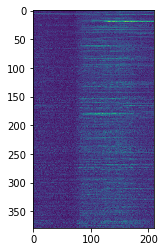

In [27]:
plt.imshow(X[5].T)

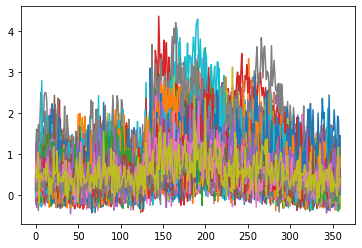

In [28]:
plt.plot(Data_x_subset[0])
plt.show()

In [29]:
X_tr.shape

(70, 360, 379)

In [30]:
n_trials = X.shape[0]
n_neurons = X.shape[2]
n_time = X.shape[1]

In [31]:
# Characterize inter/intra-slice dimensions here
#X_tr = X.transpose(0,2,1)
X_tr = X.transpose(0,2,1)

In [32]:
X_tr.shape

(70, 379, 210)

In [33]:
# default params for knn
#interslice_knn = 25
#intraslice_knn = 2

Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.72 seconds.
  Calculated multislice kernel in 11.08 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 6.58 seconds.
      Calculating KMeans...
      Calculated KMeans in 43.67 seconds.
    Calculated landmark operator in 57.50 seconds.
  Calculated graph and diffusion operator in 58.17 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 12.72 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 5.14 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 883.50 seconds.
Calculated M-PHATE in 970.66 seconds.
Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.62 seconds.
  Calculated multislice kernel in 9.35 seconds.
  Calculating

Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.63 seconds.
  Calculated multislice kernel in 8.83 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 6.61 seconds.
      Calculating KMeans...
      Calculated KMeans in 45.49 seconds.
    Calculated landmark operator in 60.23 seconds.
  Calculated graph and diffusion operator in 60.92 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 13.03 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 4.26 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 835.07 seconds.
Calculated M-PHATE in 922.20 seconds.
Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.62 seconds.
  Calculated multislice kernel in 9.51 seconds.
  Calculating 

Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.62 seconds.
  Calculated multislice kernel in 16.74 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.28 seconds.
      Calculating KMeans...
      Calculated KMeans in 40.14 seconds.
    Calculated landmark operator in 51.94 seconds.
  Calculated graph and diffusion operator in 52.74 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 11.85 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.09 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 527.74 seconds.
Calculated M-PHATE in 612.19 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.63 seconds.
  Calculated multislice kernel in 8.90 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.36 seconds.
      Calculating KMeans...
      Calculated KMeans in 39.31 seconds.
    Calculated landmark operator in 51.30 seconds.
  Calculated graph and diffusion operator in 52.09 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 12.68 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.26 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 475.48 seconds.
Calculated M-PHATE in 551.45 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.64 seconds.
  Calculated multislice kernel in 9.44 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.59 seconds.
      Calculating KMeans...
      Calculated KMeans in 40.48 seconds.
    Calculated landmark operator in 52.93 seconds.
  Calculated graph and diffusion operator in 53.74 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 11.12 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 362.32 seconds.
Calculated M-PHATE in 438.68 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.63 seconds.
  Calculated multislice kernel in 8.71 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.60 seconds.
      Calculating KMeans...
      Calculated KMeans in 40.74 seconds.
    Calculated landmark operator in 54.37 seconds.
  Calculated graph and diffusion operator in 55.15 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 12.36 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.62 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 450.78 seconds.
Calculated M-PHATE in 529.66 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.63 seconds.
  Calculated multislice kernel in 8.81 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.38 seconds.
      Calculating KMeans...
      Calculated KMeans in 39.59 seconds.
    Calculated landmark operator in 51.40 seconds.
  Calculated graph and diffusion operator in 52.20 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 13.46 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 4.37 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 720.43 seconds.
Calculated M-PHATE in 799.28 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.63 seconds.
  Calculated multislice kernel in 8.84 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.69 seconds.
      Calculating KMeans...
      Calculated KMeans in 40.61 seconds.
    Calculated landmark operator in 52.68 seconds.
  Calculated graph and diffusion operator in 53.55 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 12.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.29 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 691.44 seconds.
Calculated M-PHATE in 769.92 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.65 seconds.
  Calculated multislice kernel in 9.05 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.48 seconds.
      Calculating KMeans...
      Calculated KMeans in 40.94 seconds.
    Calculated landmark operator in 53.33 seconds.
  Calculated graph and diffusion operator in 54.15 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 13.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.32 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 448.02 seconds.
Calculated M-PHATE in 527.66 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.63 seconds.
  Calculated multislice kernel in 8.53 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.43 seconds.
      Calculating KMeans...
      Calculated KMeans in 41.03 seconds.
    Calculated landmark operator in 53.15 seconds.
  Calculated graph and diffusion operator in 53.98 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 14.01 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.34 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 873.84 seconds.
Calculated M-PHATE in 953.74 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.63 seconds.
  Calculated multislice kernel in 8.83 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.45 seconds.
      Calculating KMeans...
      Calculated KMeans in 38.51 seconds.
    Calculated landmark operator in 50.39 seconds.
  Calculated graph and diffusion operator in 51.19 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 11.68 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.05 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 840.19 seconds.
Calculated M-PHATE in 914.99 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.73 seconds.
  Calculated multislice kernel in 10.77 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.86 seconds.
      Calculating KMeans...
      Calculated KMeans in 41.55 seconds.
    Calculated landmark operator in 54.12 seconds.
  Calculated graph and diffusion operator in 54.97 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 10.71 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.96 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 455.13 seconds.
Calculated M-PHATE in 533.57 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.64 seconds.
  Calculated multislice kernel in 9.13 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 8.19 seconds.
      Calculating KMeans...
      Calculated KMeans in 40.83 seconds.
    Calculated landmark operator in 53.51 seconds.
  Calculated graph and diffusion operator in 54.39 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 12.94 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.31 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 345.36 seconds.
Calculated M-PHATE in 425.16 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.64 seconds.
  Calculated multislice kernel in 8.57 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.82 seconds.
      Calculating KMeans...
      Calculated KMeans in 43.43 seconds.
    Calculated landmark operator in 55.79 seconds.
  Calculated graph and diffusion operator in 56.64 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 12.98 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 4.48 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 455.18 seconds.
Calculated M-PHATE in 537.90 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.64 seconds.
  Calculated multislice kernel in 8.49 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.60 seconds.
      Calculating KMeans...
      Calculated KMeans in 41.42 seconds.
    Calculated landmark operator in 53.40 seconds.
  Calculated graph and diffusion operator in 54.24 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 12.45 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.24 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 432.34 seconds.
Calculated M-PHATE in 510.79 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.71 seconds.
  Calculated multislice kernel in 9.07 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.66 seconds.
      Calculating KMeans...
      Calculated KMeans in 40.28 seconds.
    Calculated landmark operator in 52.32 seconds.
  Calculated graph and diffusion operator in 53.15 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 12.35 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.21 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 655.11 seconds.
Calculated M-PHATE in 732.92 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.67 seconds.
  Calculated multislice kernel in 9.43 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.77 seconds.
      Calculating KMeans...
      Calculated KMeans in 40.45 seconds.
    Calculated landmark operator in 52.70 seconds.
  Calculated graph and diffusion operator in 53.59 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 12.58 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.27 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 618.29 seconds.
Calculated M-PHATE in 697.19 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


Calculating M-PHATE...
  Calculating multislice kernel...
    Calculating PCA...
    Calculated PCA in 0.65 seconds.
  Calculated multislice kernel in 9.06 seconds.
  Calculating graph and diffusion operator...
    Calculating landmark operator...
      Calculating SVD...
      Calculated SVD in 7.65 seconds.
      Calculating KMeans...
      Calculated KMeans in 40.40 seconds.
    Calculated landmark operator in 52.53 seconds.
  Calculated graph and diffusion operator in 53.37 seconds.
  Running PHATE on precomputed affinity matrix with 26530 cells.
  Calculating optimal t...
  Calculated optimal t in 12.25 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.34 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 589.42 seconds.
Calculated M-PHATE in 666.47 seconds.


/usr/local/lib/python3.7/site-packages/scprep/plot/utils.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw)


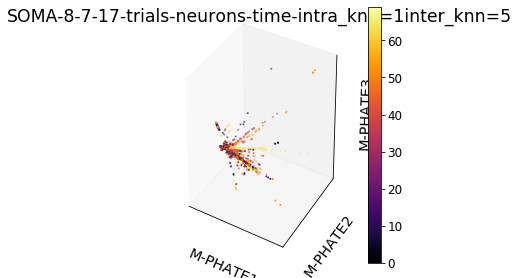

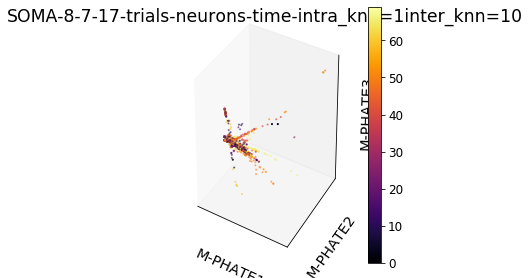

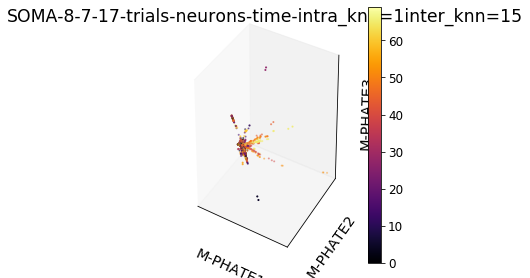

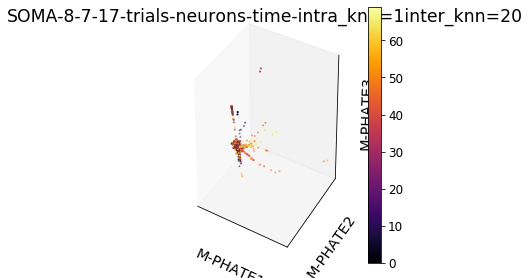

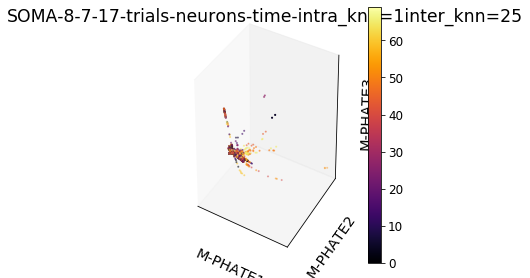

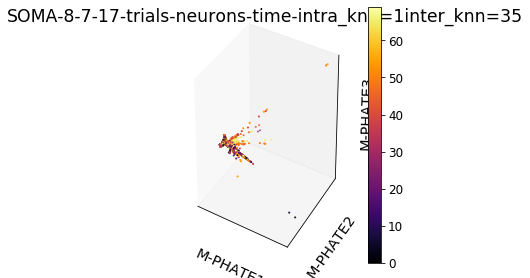

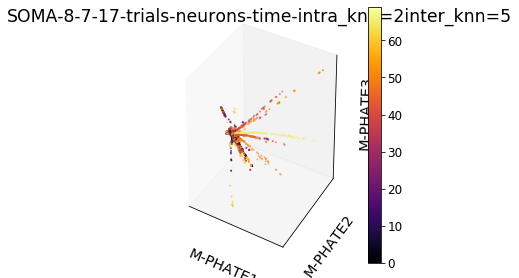

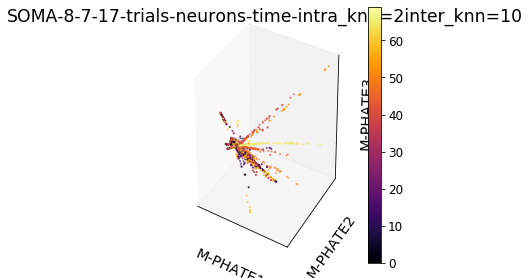

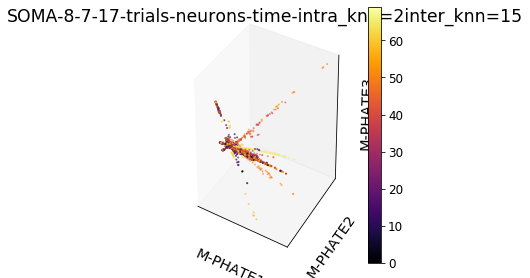

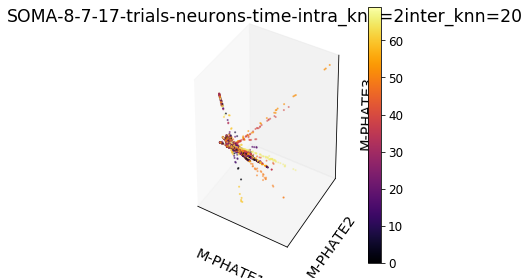

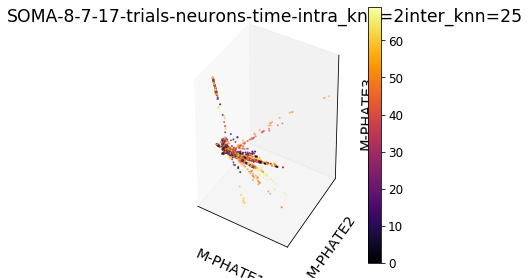

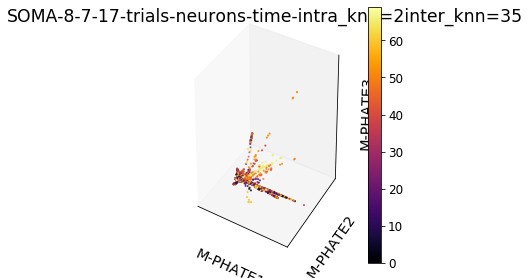

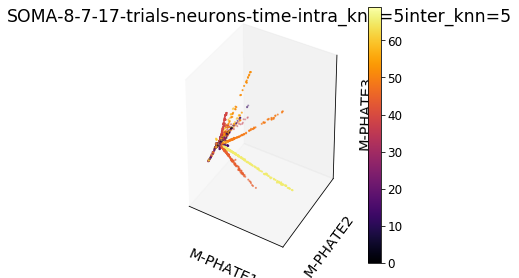

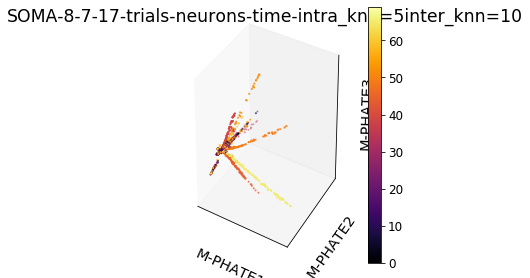

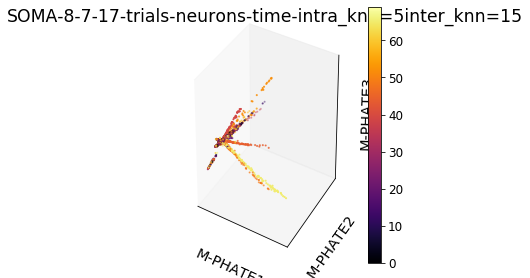

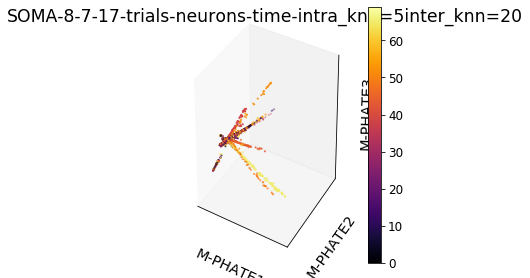

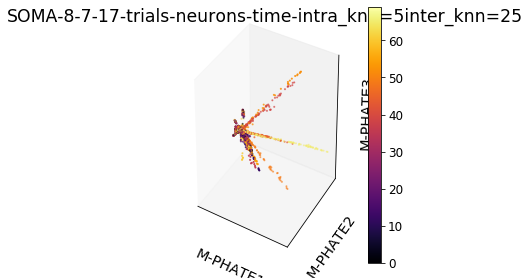

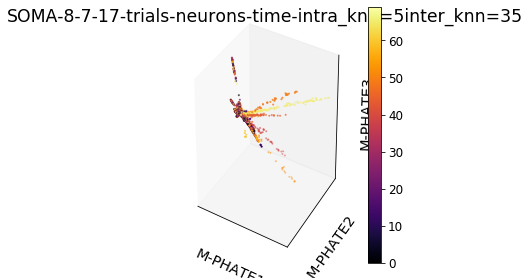

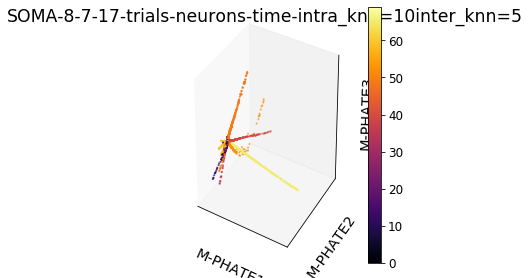

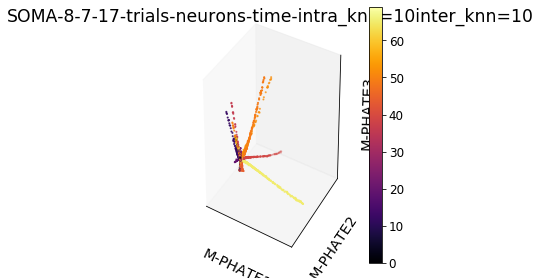

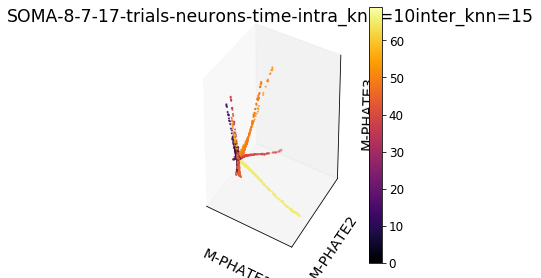

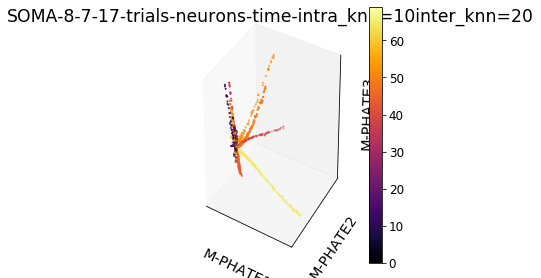

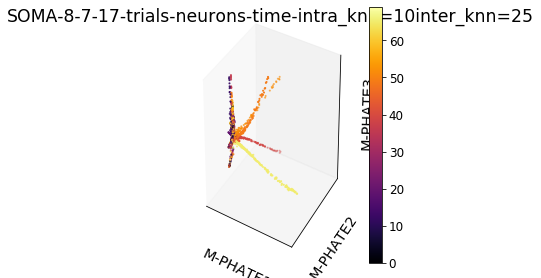

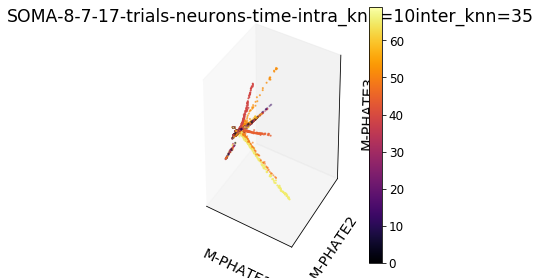

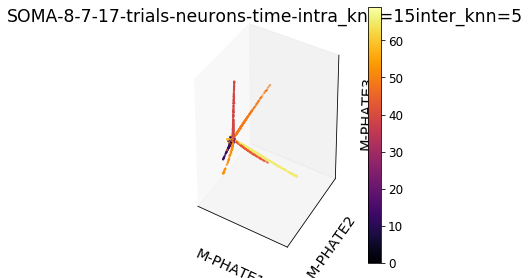

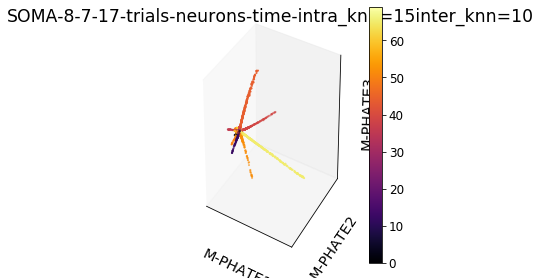

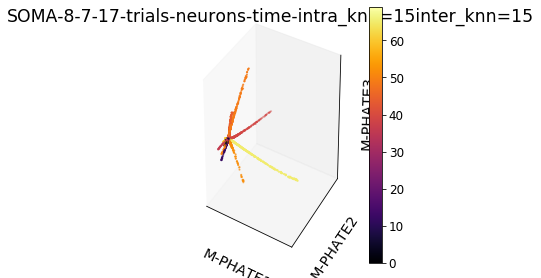

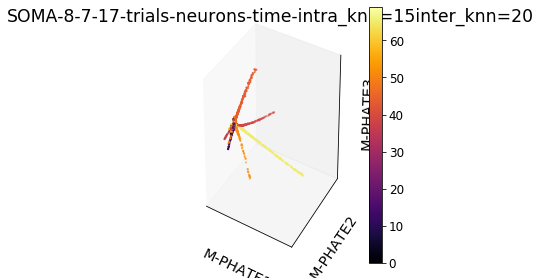

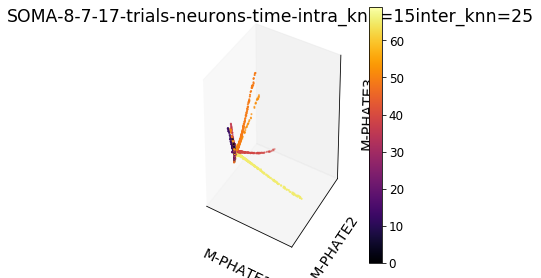

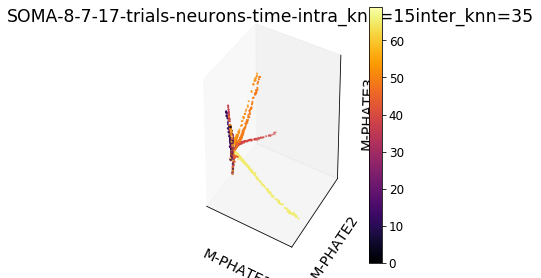

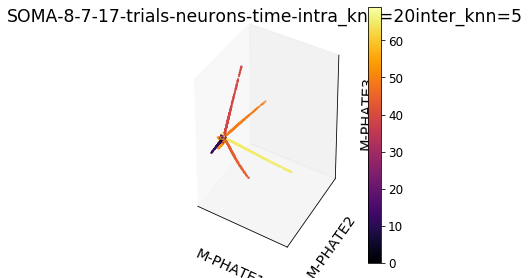

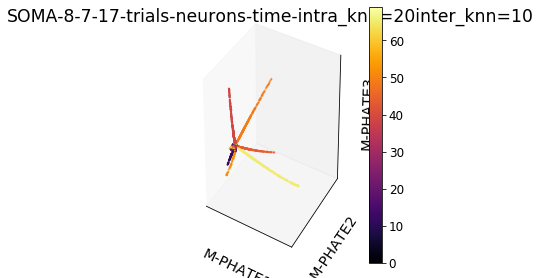

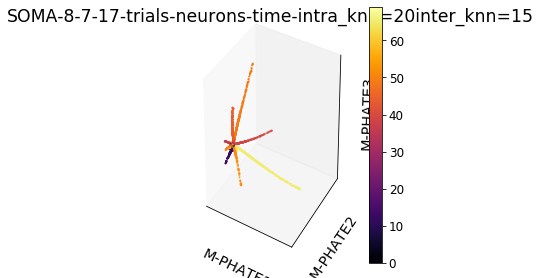

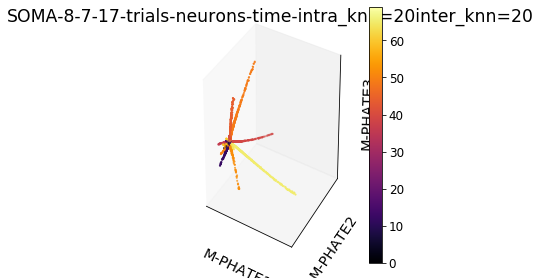

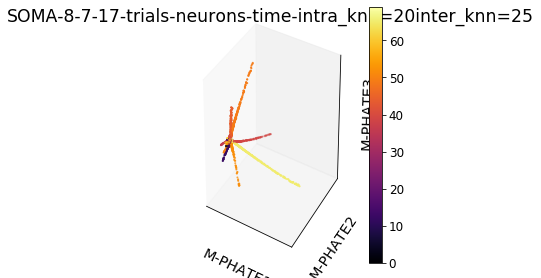

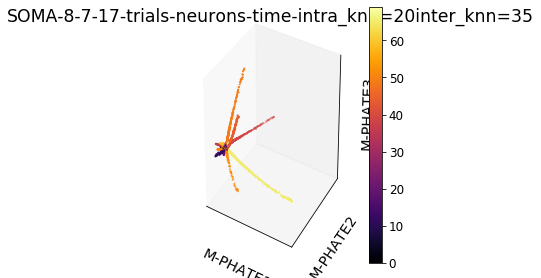

In [34]:
intra_knns = [1,2,5,10,15,20]
inter_knns = [5,10,15,20,25,35]
time = np.repeat(np.arange(n_trials),n_neurons)
for intra_knn in tqdm(intra_knns):
    for inter_knn in inter_knns:
        fname = 'SOMA-8-7-17-trials-neurons-time-intra_knn=%sinter_knn=%s' % (intra_knn, inter_knn)
        m_phate_op = m_phate.M_PHATE(normalize=False, n_components=3, n_jobs=-2, intraslice_knn=intra_knn, interslice_knn=inter_knn)
        m_phate_data = m_phate_op.fit_transform(X_tr)
        scprep.plot.scatter3d(m_phate_data, c=time, ticks=False, filename=fname+'.png', title=fname, label_prefix="M-PHATE")

In [211]:
success_ids = np.tile(Data_y_subset, n_trials)

In [206]:
m_phate_data.shape[0] / 70

379.0

In [207]:
Y_tr.flatten().shape

(1627,)

In [208]:
len(Data_y[idx])

70

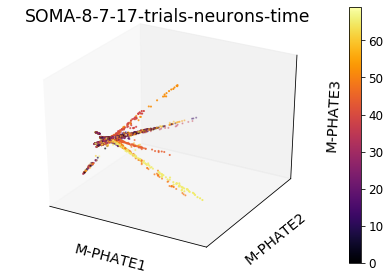

In [213]:
# plot
#n_time_steps, n_points, n_dim
#time = np.repeat(Data_y[idx], n_neurons)
#time = np.repeat(num_grabs_per_day[idx], n_neurons)
#time = success_ids
time = np.repeat(np.arange(n_trials),n_neurons)
#time = np.repeat()
scprep.plot.scatter3d(m_phate_data, c=time, ticks=False, title='SOMA-8-7-17-trials-neurons-time', label_prefix="M-PHATE",filename=None)

In [181]:
scprep.plot.rotate_scatter3d(m_phate_data, c=time, ticks=False, title='SOMA-8-7-17-trials-neurons-time', label_prefix="M-PHATE",filename=None)

In [158]:
m_phate_data.shape[0] / n_trials

379.0

In [170]:
time = np.repeat(np.arange(n_trials),1137)
scprep.plot.scatter2d(m_phate_data, c=time, ticks=False, title='SOMA-8-6-17-trials-neurons-time', label_prefix="M-PHATE",filename=None)

ValueError: Expected c of length 26530 or 1. Got 79590